In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUpPointAttention
from models_adl4cv.loss import get_repulsion_loss4
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [4]:
NPOINTS = 2048 * 2
CATEGORY = "chair"
BATCH_SIZE = 8 * 4
PATCH_SIZE = 512

In [5]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='val',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='test',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)4096 (test)4096
Total number of data:662
Min number of points: (train)4096 (test)4096
Total number of data:1317
Min number of points: (train)4096 (test)4096


In [6]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [7]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [8]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [9]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [10]:
def EMD_loss(a,b):
    return EMD(a,b, transpose=False).mean()

In [11]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    emd_loss = EMD_loss(input, output)
    repulsion_loss = get_repulsion_loss4(output)

    # Same as in https://github.com/yulequan/PU-Net/blob/master/code/model_utils.py
    return 100 * emd_loss + repulsion_loss

In [12]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

In [13]:
def subsample_patches(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,:,idx,:]

In [12]:
model = PVCNNUpPointAttention(num_classes=3, num_shapes=3, extra_feature_channels=0, attention=True, attn_dim=256).to("cuda")
model

PVCNNUpPointAttention(
  (point_features): ModuleList(
    (0): PVConv(
      (voxelization): Voxelization(resolution=32)
      (voxel_layers): Sequential(
        (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): Swish()
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): Swish()
        (6): SE3d(
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=8, bias=False)
            (1): Swish()
            (2): Linear(in_features=8, out_features=64, bias=False)
            (3): Sigmoid()
          )
        )
      )
      (point_features): SharedMLP(
        (layers): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): Swish()
        )
      )
    )
    (1): PVConv(
      (vo

In [15]:
noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3))
subsampled_noise = subsample(noise)

print(noise.shape, subsampled_noise.shape)

noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3)).to("cuda")
noise_subsample = subsample(noise)

torch.Size([8, 4096, 3]) torch.Size([8, 2048, 3])


In [25]:
# Random patch
patched_input = get_nearest_neighbors_batch_pytorch3d(noise_subsample, 512).transpose(1,2)

patched_input.shape

torch.Size([8, 3, 512])

In [26]:
patched_input = generate_non_overlapping_patches(noise_subsample).transpose(2,3)
patched_input.shape

torch.Size([4, 8, 3, 512])

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

7929859

In [16]:
output = model(noise_subsample[:10, ...].transpose(1,2)).transpose(1,2)

noise.shape, output.shape

torch.Size([8, 4096, 3, 1])


(torch.Size([8, 4096, 3]), torch.Size([8, 4096, 3]))

In [17]:
emd_loss = EMD_loss(noise, output)
emd_loss

tensor(2.4672, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

LEARNING_RATE_CLIP = 1e-5
DECCAY_STEP = 5
LEARNING_RATE = 3e-4
LEARNING_RATE_DECAY = 0.5

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [14]:
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0
    
    # Point Transformer Learning Rate Scheduling
    lr = max(LEARNING_RATE * (LEARNING_RATE_DECAY ** (epoch // DECCAY_STEP)), LEARNING_RATE_CLIP)
    print('Learning rate:%f' % lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Train
    model.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/100 Training') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
            input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            optimizer.zero_grad()
            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            loss = combined_loss(patched_input, output)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            tbar.set_postfix(loss=total_train_loss / (tbar.n + 1))

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Validate
    model.eval()
    with torch.no_grad(), tqdm(val_dataloader, desc=f'Epoch {epoch+1}/100 Validating') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
            input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            val_loss = combined_loss(patched_input, output)
            total_val_loss += val_loss.item()
            tbar.set_postfix(loss=total_val_loss / (tbar.n + 1))

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(json.dumps({"Epoch": epoch+1, "Training Loss": epoch_train_loss, "Validation Loss": epoch_val_loss}))

    # Save the model
    model_save_path = f"output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break


writer.close()


Epoch 1/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

Learning rate:0.000300


Epoch 2/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 1, "Training Loss": 39.74532184335921, "Validation Loss": 15.318629455566406}
Learning rate:0.000300


Epoch 3/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 2, "Training Loss": 11.982140488094753, "Validation Loss": 10.992411041259766}
Learning rate:0.000300


Epoch 4/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 3, "Training Loss": 10.4952050016986, "Validation Loss": 9.64171838760376}
Learning rate:0.000300


Epoch 5/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 4, "Training Loss": 9.88621735241678, "Validation Loss": 9.081720900535583}
Learning rate:0.000300


Epoch 6/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 5, "Training Loss": 9.50637329618136, "Validation Loss": 9.317097282409668}
No improvement in validation loss for 1 epochs.
Learning rate:0.000150


Epoch 7/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 6, "Training Loss": 9.144215487771564, "Validation Loss": 8.879649209976197}
Learning rate:0.000150


Epoch 8/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 7, "Training Loss": 9.063510368267695, "Validation Loss": 8.591815996170045}
Learning rate:0.000150


Epoch 9/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 8, "Training Loss": 8.931250797377693, "Validation Loss": 8.791956162452697}
No improvement in validation loss for 1 epochs.
Learning rate:0.000150


Epoch 10/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 9, "Training Loss": 9.063603768746058, "Validation Loss": 8.791578984260559}
No improvement in validation loss for 2 epochs.
Learning rate:0.000150


Epoch 11/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 10, "Training Loss": 8.829919675985971, "Validation Loss": 8.368884682655334}
Learning rate:0.000075


Epoch 12/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 11, "Training Loss": 8.596330102947023, "Validation Loss": 8.465670251846314}
No improvement in validation loss for 1 epochs.
Learning rate:0.000075


Epoch 13/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 12, "Training Loss": 8.701423135068682, "Validation Loss": 8.3430251121521}
Learning rate:0.000075


Epoch 14/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 13, "Training Loss": 8.56585195991728, "Validation Loss": 8.738993573188782}
No improvement in validation loss for 1 epochs.
Learning rate:0.000075


Epoch 15/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 14, "Training Loss": 8.52248591515753, "Validation Loss": 8.462238979339599}
No improvement in validation loss for 2 epochs.
Learning rate:0.000075


Epoch 16/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 15, "Training Loss": 8.347879793908861, "Validation Loss": 8.793004775047303}
No improvement in validation loss for 3 epochs.
Learning rate:0.000037


Epoch 17/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 16, "Training Loss": 8.42869809601042, "Validation Loss": 8.068496942520142}
Learning rate:0.000037


Epoch 18/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 17, "Training Loss": 8.357245100869072, "Validation Loss": 7.921875071525574}
Learning rate:0.000037


Epoch 19/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 18, "Training Loss": 8.29399859905243, "Validation Loss": 8.099086046218872}
No improvement in validation loss for 1 epochs.
Learning rate:0.000037


Epoch 20/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 19, "Training Loss": 8.252713114023209, "Validation Loss": 8.35847237110138}
No improvement in validation loss for 2 epochs.
Learning rate:0.000037


Epoch 21/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 20, "Training Loss": 8.317751261923048, "Validation Loss": 8.234041428565979}
No improvement in validation loss for 3 epochs.
Learning rate:0.000019


Epoch 22/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 21, "Training Loss": 8.203783512115479, "Validation Loss": 8.085535836219787}
No improvement in validation loss for 4 epochs.
Learning rate:0.000019


Epoch 23/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 22, "Training Loss": 8.191655420594746, "Validation Loss": 8.084990572929382}
No improvement in validation loss for 5 epochs.
Learning rate:0.000019


Epoch 24/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 23, "Training Loss": 8.17925755182902, "Validation Loss": 7.802763676643371}
Learning rate:0.000019


Epoch 25/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 24, "Training Loss": 8.070452554358376, "Validation Loss": 7.93084032535553}
No improvement in validation loss for 1 epochs.
Learning rate:0.000019


Epoch 26/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 25, "Training Loss": 8.133496953381432, "Validation Loss": 7.942709803581238}
No improvement in validation loss for 2 epochs.
Learning rate:0.000010


Epoch 27/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 26, "Training Loss": 7.973059541649288, "Validation Loss": 8.026186776161193}
No improvement in validation loss for 3 epochs.
Learning rate:0.000010


Epoch 28/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 27, "Training Loss": 8.130811591943106, "Validation Loss": 7.645975947380066}
Learning rate:0.000010


Epoch 29/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 28, "Training Loss": 8.029952519469791, "Validation Loss": 8.36568524837494}
No improvement in validation loss for 1 epochs.
Learning rate:0.000010


Epoch 30/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 29, "Training Loss": 8.044526216056612, "Validation Loss": 8.129686117172241}
No improvement in validation loss for 2 epochs.
Learning rate:0.000010


Epoch 31/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 30, "Training Loss": 8.043775531980726, "Validation Loss": 8.13713960647583}
No improvement in validation loss for 3 epochs.
Learning rate:0.000010


Epoch 32/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 31, "Training Loss": 8.09009759955936, "Validation Loss": 8.107518982887267}
No improvement in validation loss for 4 epochs.
Learning rate:0.000010


Epoch 33/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 32, "Training Loss": 8.265584210554758, "Validation Loss": 7.916136264801025}
No improvement in validation loss for 5 epochs.
Learning rate:0.000010


Epoch 34/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 33, "Training Loss": 8.070090764098698, "Validation Loss": 8.273354864120483}
No improvement in validation loss for 6 epochs.
Learning rate:0.000010


Epoch 35/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 34, "Training Loss": 8.079594764444563, "Validation Loss": 8.550473475456238}
No improvement in validation loss for 7 epochs.
Learning rate:0.000010


Epoch 36/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 35, "Training Loss": 8.060825520091587, "Validation Loss": 7.936727833747864}
No improvement in validation loss for 8 epochs.
Learning rate:0.000010


Epoch 37/100 Training:   0%|          | 0/144 [00:00<?, ?it/s]

{"Epoch": 36, "Training Loss": 8.07107068763839, "Validation Loss": 8.00563395023346}
No improvement in validation loss for 9 epochs.
Learning rate:0.000010


Epoch 37/100 Validating: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s, loss=8.15]

{"Epoch": 37, "Training Loss": 8.142438325617048, "Validation Loss": 8.150861859321594}
No improvement in validation loss for 10 epochs.
Stopping early due to no improvement in validation loss.


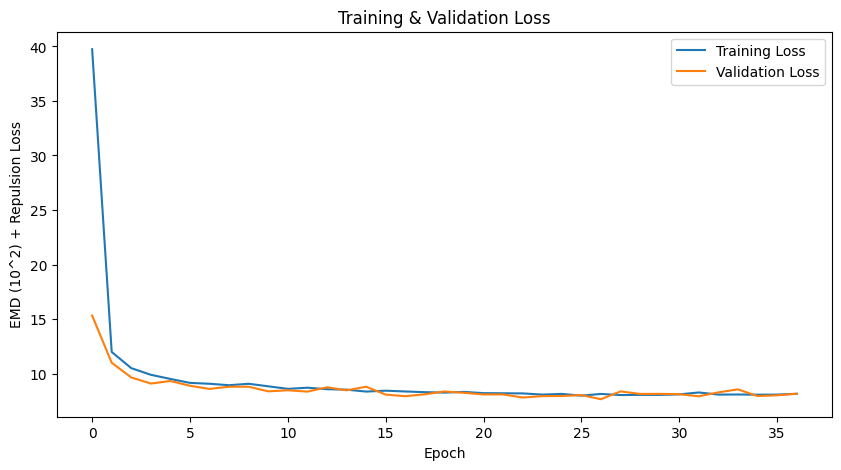

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('EMD (10^2) + Repulsion Loss')
plt.legend()
plt.show()

torch.Size([4096, 3]) torch.Size([3, 32, 512]) torch.Size([4096, 3])


ValueError: shapes (3,32,512) and (3,3) not aligned: 512 (dim 2) != 3 (dim 0)

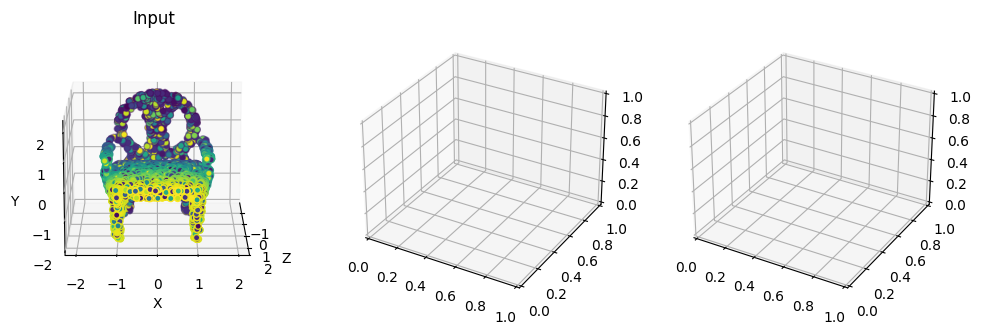

In [30]:
INDEX = 0
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches[INDEX, ...].detach().transpose(0,1)
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's visualize some examples

In [14]:
# Run this if you need to load the model.

model = PVCNNUpPointAttention(num_classes=3, num_shapes=3, extra_feature_channels=0, attention=True, attn_dim=256).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-e36.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [28]:
model.eval()

total_test_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        # Select a random patch with double the size, then downsample, then add noise.
        patched_input = generate_non_overlapping_patches(input, PATCH_SIZE * 2)
        input_downsampled = subsample_patches(patched_input, npoints=PATCH_SIZE)
        noised_downsampled_patches = add_random_noise(input_downsampled).transpose(2,3)
        
        refined_patches = []
        for patch in noised_downsampled_patches:
            output = model(patch).to("cuda").transpose(1,2)
            refined_patches.append(output)
        
        output = torch.stack(refined_patches).transpose(0,1).reshape(BATCH_SIZE, NPOINTS, 3)
        
        input_arr.append(input)
        output_arr.append(output)

        loss = combined_loss(input, output)
        total_test_loss += loss.item()
        print(f"Batch {i}, EMD + Repulsion Loss: {loss.item():.4f}")

average_loss = total_test_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

Batch 0, EMD + Repulsion Loss: 12.3938
Batch 1, EMD + Repulsion Loss: 11.7522
Batch 2, EMD + Repulsion Loss: 11.7691
Batch 3, EMD + Repulsion Loss: 12.2197
Batch 4, EMD + Repulsion Loss: 11.5540
Batch 5, EMD + Repulsion Loss: 13.2613
Batch 6, EMD + Repulsion Loss: 12.4619
Batch 7, EMD + Repulsion Loss: 12.8365
Batch 8, EMD + Repulsion Loss: 14.1050
Batch 9, EMD + Repulsion Loss: 14.3420
Batch 10, EMD + Repulsion Loss: 11.8116
Batch 11, EMD + Repulsion Loss: 11.7928
Batch 12, EMD + Repulsion Loss: 13.4245
Batch 13, EMD + Repulsion Loss: 12.6397
Batch 14, EMD + Repulsion Loss: 11.7240
Batch 15, EMD + Repulsion Loss: 14.4555
Batch 16, EMD + Repulsion Loss: 12.6631
Batch 17, EMD + Repulsion Loss: 12.2675
Batch 18, EMD + Repulsion Loss: 10.6869
Batch 19, EMD + Repulsion Loss: 12.5360
Batch 20, EMD + Repulsion Loss: 12.6965
Batch 21, EMD + Repulsion Loss: 12.7495
Batch 22, EMD + Repulsion Loss: 12.5686
Batch 23, EMD + Repulsion Loss: 11.4965
Batch 24, EMD + Repulsion Loss: 11.1597
Batch 25, 

In [45]:
noised_downsampled_patches_comb = noised_downsampled_patches.transpose(0,1).transpose(2,3).reshape(BATCH_SIZE, NPOINTS // 2, 3)
noised_downsampled_patches_comb.shape

torch.Size([32, 2048, 3])

torch.Size([4096, 3]) torch.Size([2048, 3]) torch.Size([4096, 3])


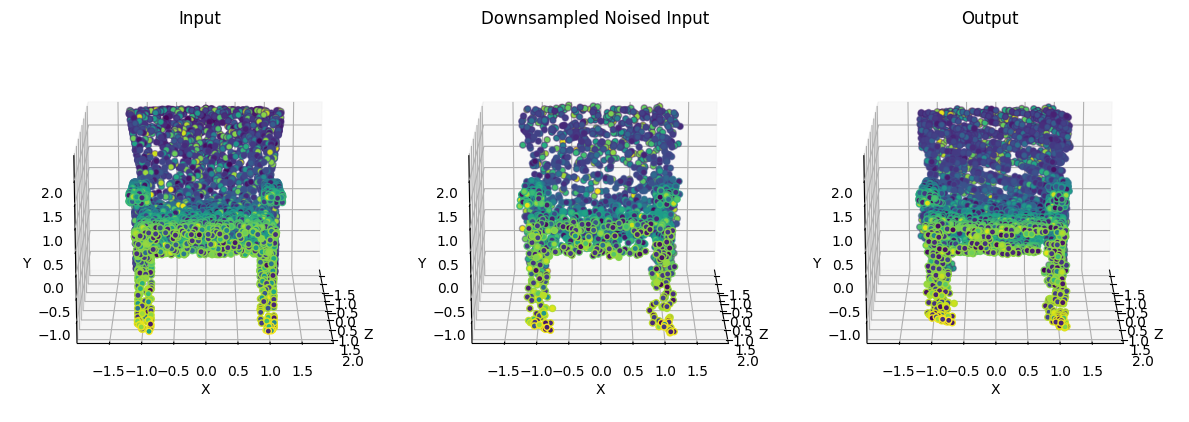

In [55]:
INDEX = 8
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches_comb[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's now try to imrpove the dataset of PVD

In [15]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=[CATEGORY], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

final_val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [21]:
input_array = []

for batch in final_val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [78]:
model.eval()

output_array = []
for batch in tqdm(dataloader_pvd):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        # Select a random patch with double the size, then downsample, then add noise.
        patched_input = generate_non_overlapping_patches(input, PATCH_SIZE).transpose(2,3)
        refined_patches = []
        for patch in patched_input:
            output = model(patch).to("cuda").transpose(1,2)
            refined_patches.append(output)
        
        output = torch.stack(refined_patches).transpose(0,1).reshape(20, NPOINTS, 3)
        output_array.append(output)

100%|██████████| 20/20 [00:12<00:00,  1.68it/s]


In [75]:
len(input_array), len(output_array)

(33, 20)

In [76]:
input_pcs = torch.stack(input_array[:20]).view(400, NPOINTS, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 4096, 3]), torch.Size([400, 4096, 3]))

In [94]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


  1%|          | 4/400 [00:08<14:44,  2.23s/it]

In [ ]:
torch.save({"results": results} , "chair_results.pth")

In [1]:
import torch
results = torch.load("./chair_results.pth")
results

{'results': {'lgan_mmd-CD': 0.08294851332902908,
  'lgan_cov-CD': 0.5249999761581421,
  'lgan_mmd_smp-CD': 0.09745326638221741,
  'lgan_mmd-EMD': 0.5428878664970398,
  'lgan_cov-EMD': 0.5450000166893005,
  'lgan_mmd_smp-EMD': 0.596518337726593,
  '1-NN-CD-acc_t': 0.625,
  '1-NN-CD-acc_f': 0.5049999952316284,
  '1-NN-CD-acc': 0.5649999976158142,
  '1-NN-EMD-acc_t': 0.625,
  '1-NN-EMD-acc_f': 0.5525000095367432,
  '1-NN-EMD-acc': 0.5887500047683716}}

In [ ]:
chair = {
    'lgan_mmd-CD': 0.08294851332902908,
  'lgan_cov-CD': 0.5249999761581421,
  'lgan_mmd_smp-CD': 0.09745326638221741,
  'lgan_mmd-EMD': 0.5428878664970398,
  'lgan_cov-EMD': 0.5450000166893005,
  'lgan_mmd_smp-EMD': 0.596518337726593,
  '1-NN-CD-acc_t': 0.625,
  '1-NN-CD-acc_f': 0.5049999952316284,
  '1-NN-CD-acc': 0.5649999976158142,
  '1-NN-EMD-acc_t': 0.625,
  '1-NN-EMD-acc_f': 0.5525000095367432,
  '1-NN-EMD-acc': 0.5887500047683716
  }

# NNA-CD: 56.49%
# NNA-EMD: 58.87%

torch.Size([2048, 3]) torch.Size([4096, 3])


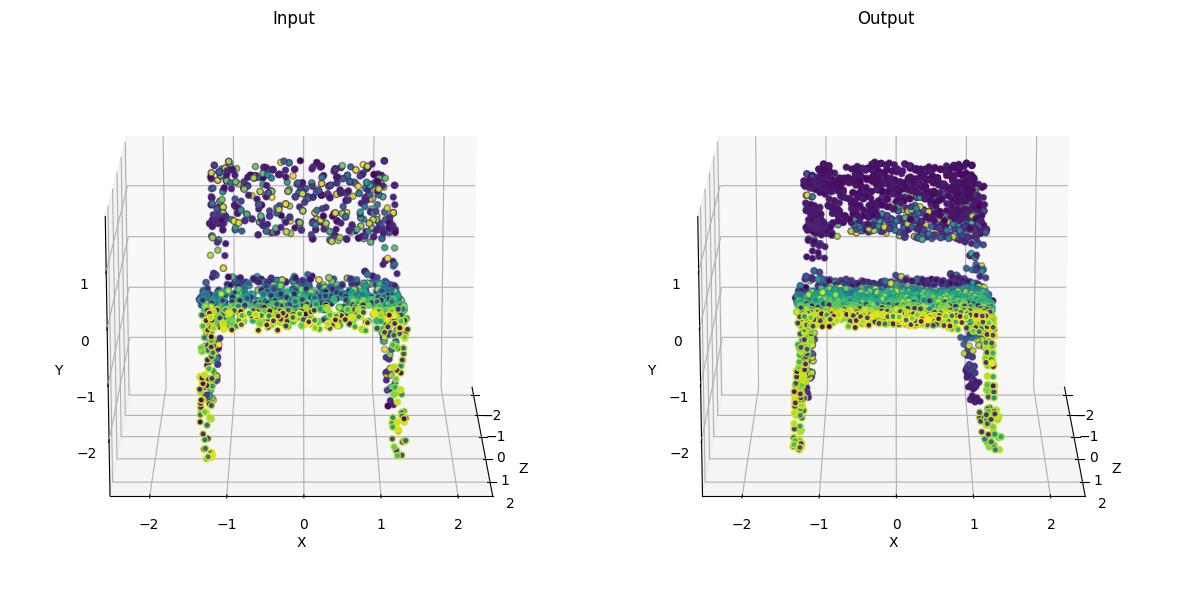

In [89]:
INDEX = 5
input_pc = input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [50]:
chamfer_distance(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0049, device='cuda:0')

In [51]:
EMD_loss(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.2859, device='cuda:0')

In [52]:
get_repulsion_loss4(output_pc.unsqueeze(0))

tensor(0.0700, device='cuda:0')

In [90]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015)

Center: [ 0.03333604 -0.5193562  -0.08203131], Scale: 4.76811408996582
Center: [-0.0136863  -0.46800745 -0.0805679 ], Scale: 4.611741065979004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


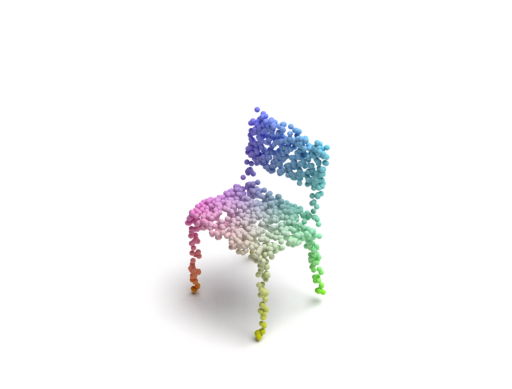

In [91]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

# Let's try part segmentation and then refinement.

In [16]:
from models_adl4cv.pvcnn import PVCNNPartSeg

In [18]:
part_model = PVCNNPartSeg(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-refinement-patch-chair/PVCNN-Baseline-Refinement-Patch-e76.pth"))

<All keys matched successfully>

In [19]:
model.eval()

pvd_output = []
output_array = []

patched_input = []
patched_refined = []

with torch.no_grad():
    for batch in tqdm(dataloader_pvd):
        input = batch["test_points"].to("cuda")
        pvd_output.append(input)

        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        output_batch = []

        for (sample, seg) in zip(input, input_seg):
            output_tensor = []

            for i in range(seg.max() + 1):
                part_input = sample[seg==i, :]
                
                # Patched input
                patched_input.append(part_input)

                output = model(part_input.unsqueeze(0).transpose(1,2))
                output = output.squeeze().transpose(0,1)

                #Refined patch
                patched_refined.append(output)

                output_tensor.append(output)

            output_tensor = torch.cat(output_tensor)
            output_batch.append(output_tensor.unsqueeze(0))
        
        output_batch = torch.cat(output_batch)
        output_array.append(output_batch)

100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


In [25]:
input_pcs = torch.stack(input_array[:20]).view(400, NPOINTS, 3)
pvd_output_pcs = torch.stack(pvd_output).view(400, NPOINTS // 2, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape, pvd_output_pcs.shape

(torch.Size([400, 4096, 3]),
 torch.Size([400, 4096, 3]),
 torch.Size([400, 2048, 3]))

torch.Size([2048, 3]) torch.Size([4096, 3])


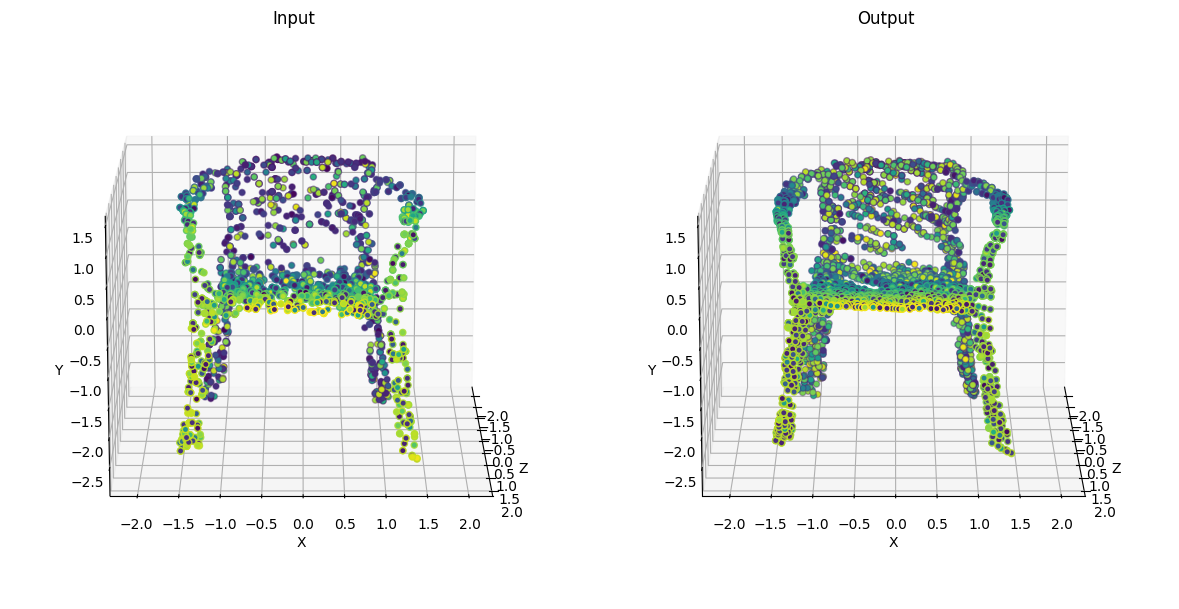

In [43]:
INDEX = 13
input_pc = pvd_output_pcs[INDEX, ...].detach()
output_pc = output_pcs[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [44]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015)

Center: [ 0.02204186 -0.6525706   0.12306881], Scale: 4.433474540710449
Center: [ 0.02340651 -0.6396613   0.14104116], Scale: 4.279245853424072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


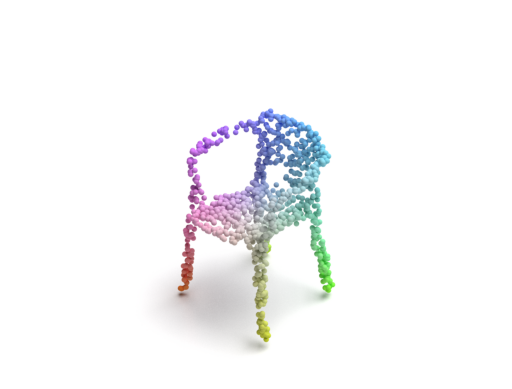

In [45]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


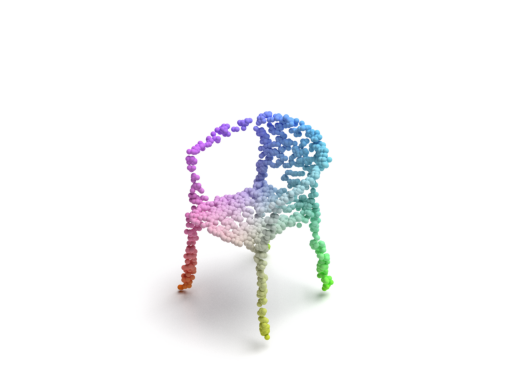

In [46]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [48]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [14:53<00:00,  2.23s/it]

{'lgan_mmd-CD': 0.08323029428720474, 'lgan_cov-CD': 0.5224999785423279, 'lgan_mmd_smp-CD': 0.097198985517025, 'lgan_mmd-EMD': 0.5473935604095459, 'lgan_cov-EMD': 0.5625, 'lgan_mmd_smp-EMD': 0.5919324159622192, '1-NN-CD-acc_t': 0.6949999928474426, '1-NN-CD-acc_f': 0.5049999952316284, '1-NN-CD-acc': 0.6000000238418579, '1-NN-EMD-acc_t': 0.6349999904632568, '1-NN-EMD-acc_f': 0.5774999856948853, '1-NN-EMD-acc': 0.606249988079071}


In [49]:
torch.save({"results": results} , "chair_part_results.pth")

In [ ]:
import torch
results = torch.load("./chair_part_results.pth")
results

In [ ]:
chair = {
    "lgan_mmd-CD": 0.08323029428720474,
    "lgan_cov-CD": 0.5224999785423279,
    "lgan_mmd_smp-CD": 0.097198985517025,
    "lgan_mmd-EMD": 0.5473935604095459,
    "lgan_cov-EMD": 0.5625,
    "lgan_mmd_smp-EMD": 0.5919324159622192,
    "1-NN-CD-acc_t": 0.6949999928474426,
    "1-NN-CD-acc_f": 0.5049999952316284,
    "1-NN-CD-acc": 0.6000000238418579,
    "1-NN-EMD-acc_t": 0.6349999904632568,
    "1-NN-EMD-acc_f": 0.5774999856948853,
    "1-NN-EMD-acc": 0.606249988079071,
}

# 1-NNA-CD: 60%
# 1-NNA-EMD: 60%